# Transfer Learning Example (VGGNet) - Flower Power

In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a fixed feature extractor. We are using it to classify images of flowers. 

Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

<img src="assets/vgg_16_architecture.png" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use VGGNet as a _fixed feature extractor_ for our images then easily train a simple classifier on top of that. 
* Use all but the last fully-connected layer as a fixed feature extractor. (Note: We actually train the 2nd and 3rd last fc layers to be precise.)
* Define a new, final classification layer and apply it to a task of our choice!

You can read more about transfer learning from [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-check-device" data-toc-modified-id="Import-libraries,-check-device-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, check device</a></span></li><li><span><a href="#Load-and-Transform-our-Data" data-toc-modified-id="Load-and-Transform-our-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Transform our Data</a></span><ul class="toc-item"><li><span><a href="#DataLoaders-and-Data-Visualization" data-toc-modified-id="DataLoaders-and-Data-Visualization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>DataLoaders and Data Visualization</a></span></li></ul></li><li><span><a href="#Define-the-Model" data-toc-modified-id="Define-the-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define the Model</a></span><ul class="toc-item"><li><span><a href="#Replace-Final-Classifier-Layer" data-toc-modified-id="Replace-Final-Classifier-Layer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Replace Final Classifier Layer</a></span></li><li><span><a href="#Specify-Loss-Function-and-Optimizer" data-toc-modified-id="Specify-Loss-Function-and-Optimizer-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Specify <a href="http://pytorch.org/docs/stable/nn.html#loss-functions" target="_blank">Loss Function</a> and <a href="http://pytorch.org/docs/stable/optim.html" target="_blank">Optimizer</a></a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Visualize-Sample-Test-Results" data-toc-modified-id="Visualize-Sample-Test-Results-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Visualize Sample Test Results</a></span></li></ul></li></ul></div>

## Import libraries, check device

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class. The root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [3]:
# Define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# Classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

**Note:** When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [4]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# Print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [5]:
# Define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

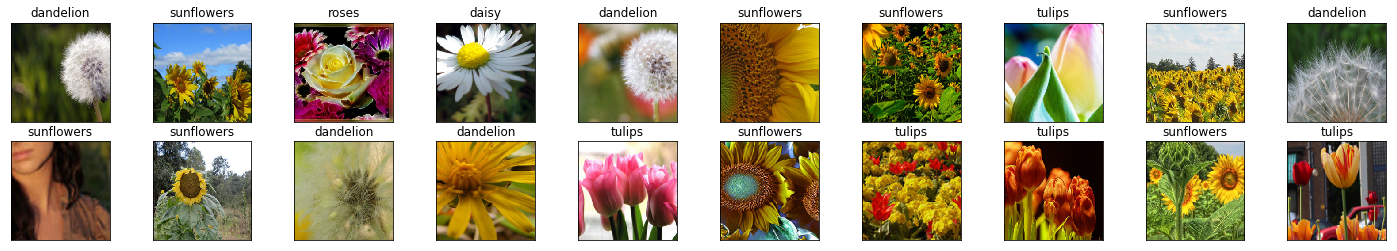

In [6]:
# Visualize some sample data

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 59258232.45it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
# Check the final layer params
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [9]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

### Replace Final Classifier Layer

In [10]:
## Add a last linear layer  that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True
n_inputs = vgg16.classifier[6].in_features
n_outpus = len(classes)
vgg16.classifier[6] = nn.Linear(n_inputs, n_outpus)

# Check result
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=5, bias=True)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [11]:
# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

---
## Training

As we use a pretrained NN we should see reasonable performance after 2 epochs only.

In [12]:
# Write device agnostic code which will automatically use CUDA if it's enabled
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(f"Device: {device}")

# Move model to device
vgg16 = vgg16.to(device)

Device: cuda:0


In [14]:
# number of epochs to train the model
n_epochs = 2

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time

for epoch in range(n_epochs):
    running_loss = 0
    for n_batch, (images, labels) in enumerate(train_loader):
        # Move input and label tensors to the GPU
        images, labels = images.to(device), labels.to(device)

        probs = vgg16.forward(images)
        loss = criterion(probs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
        if n_batch % 20 == 19:    # print training loss every specified number of mini-batches
            print(f'Epoch {epoch+1:d} Batch {n_batch+1:d} loss: {running_loss/20:.16}')
            running_loss = 0.0

Epoch 1 Batch 20 loss: 0.9932857990264893
Epoch 1 Batch 40 loss: 0.9516475588083267
Epoch 1 Batch 60 loss: 0.9194159209728241
Epoch 1 Batch 80 loss: 0.9163479268550873
Epoch 1 Batch 100 loss: 0.8576120585203171
Epoch 1 Batch 120 loss: 0.8613268435001373
Epoch 1 Batch 140 loss: 0.8197395831346512
Epoch 2 Batch 20 loss: 0.7731053605675697
Epoch 2 Batch 40 loss: 0.7607943013310432
Epoch 2 Batch 60 loss: 0.7597178146243095
Epoch 2 Batch 80 loss: 0.6877529591321945
Epoch 2 Batch 100 loss: 0.7404010087251663
Epoch 2 Batch 120 loss: 0.7169973626732826
Epoch 2 Batch 140 loss: 0.6657149538397789


---
## Testing

Below you see the test accuracy for each flower class.

In [15]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.678890

Test Accuracy of daisy: 80% (74/92)
Test Accuracy of dandelion: 87% (115/132)
Test Accuracy of roses: 72% (66/91)
Test Accuracy of sunflowers: 74% (75/101)
Test Accuracy of tulips: 65% (81/124)

Test Accuracy (Overall): 76% (411/540)


### Visualize Sample Test Results

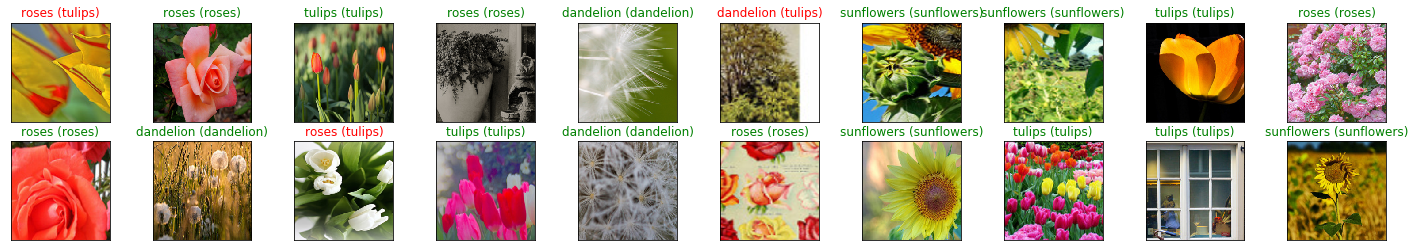

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

---